In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import torch


from PIL import Image
import torch
from torchvision import models, transforms
from sklearn.neighbors import NearestNeighbors
import os
import glob

import faiss

import clip
from PIL import Image

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Models
- https://pytorch.org/vision/stable/models.html
- load your neural netwrok for feature extraction

In [3]:
# Swin

from torchvision.models import swin_v2_b, Swin_B_Weights
model = models.swin_v2_b(weights=Swin_B_Weights).to(device).eval()


total_params = sum(p.numel() for p in model.parameters())
total_params

/home/amir/miniconda3/envs/faiss/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Swin_V2_B_Weights.IMAGENET1K_V1`. You can also use `weights=Swin_V2_B_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


87930848

In [ ]:
model

In [4]:
# ResNet

from torchvision.models import resnet50, ResNet50_Weights
model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2).to(device).eval()
# model = models.resnet50(pretrained=True)


total_params = sum(p.numel() for p in model.parameters())
total_params

25557032

In [ ]:
model

In [9]:
# RegNet

model = models.regnet_y_400mf(pretrained=True).to(device).eval()



total_params = sum(p.numel() for p in model.parameters())
total_params

/home/amir/miniconda3/envs/faiss/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/amir/miniconda3/envs/faiss/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RegNet_Y_400MF_Weights.IMAGENET1K_V1`. You can also use `weights=RegNet_Y_400MF_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


4344144

In [10]:
model

RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 48, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=6, bias=False)
            

# Dataloader

### NAIP

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import torchvision.transforms as transforms

class NAIP(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = []

        # Recursively collect all image file paths
        for subdir, dirs, files in os.walk(root_dir):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):
                    self.image_files.append(os.path.join(subdir, file))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        image = Image.open(img_name).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image

# Define the root directory containing the images
root_dir = 'datasets/naip'

# Define any transformations you want to apply to the images
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Example transformation
    transforms.ToTensor()
])

# Create the dataset
naip_dataset = NAIP(root_dir=root_dir, transform=transform)

# Create dataloaders
batch_size = 4

train_loader = DataLoader(naip_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(naip_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Example of iterating through the dataset
# for images in train_loader:
#     print(images.size())
    # Here you can add your training code


In [ ]:
sample = next(iter(train_loader))

plt.imshow(sample[0].permute(1, 2, 0))

# Metrics

# Vector Database
- Store features in the VD
- I use FAISS

## Store in basic Python List

In [5]:
# Walk into directoies to find images and convert them to vectors
image_paths = []
features = []
for root, dirs, files in os.walk('datasets/'):
    for file in files:
        if file.endswith((".jpg", ".tif", ".png")):
            file_path = os.path.join(root, file)
            
            img = torch.tensor(np.array(Image.open(file_path)), dtype=torch.float32)[:,:,:3]
            img = img.permute(2, 0, 1).unsqueeze(0)


            with torch.no_grad():
                feature = model(img.to(device)).detach().cpu().numpy()
                
            image_paths.append(file_path)
            features.append(feature)



print(len(features), ' Images Found!')
features = np.concatenate(features, axis=0)

5071  Images Found!


**Swin**
- Took 2m 18s to complete on NVIDIA 3060
- Took 2m 44s  


**ResNet**  
- Took 34s

### NN Search

In [9]:
query_image_path = 'datasets/RESISC45_partial/airplane/airplane_003.jpg'
query = torch.tensor(np.array(Image.open(query_image_path)), dtype=torch.float32)[:,:,:3]
query = query.permute(2, 0, 1).unsqueeze(0)

with torch.no_grad():
    query_feature = model(query.to(device)).detach().cpu().numpy()

In [10]:
k = 20

neigh = NearestNeighbors(n_neighbors=k, algorithm='brute')
neigh.fit(features)
distances, indices = neigh.kneighbors(query_feature)

# Print the results
for i in range(k):
    print(f"Image {i+1}:")
    print(f"Distance: {distances[0][i]:.4f}")
    print(f"Index: {indices[0][i]}")
    print(f"Image Path: {image_paths[indices[0][i]]}")
    print()

Image 1:
Distance: 0.0000
Index: 1717
Image Path: datasets/RESISC45_partial/airplane/airplane_003.jpg

Image 2:
Distance: 117.9385
Index: 1675
Image Path: datasets/RESISC45_partial/airplane/airplane_530.jpg

Image 3:
Distance: 127.5935
Index: 2059
Image Path: datasets/RESISC45_partial/airplane/airplane_469.jpg

Image 4:
Distance: 146.0717
Index: 1475
Image Path: datasets/RESISC45_partial/airplane/airplane_693.jpg

Image 5:
Distance: 156.5480
Index: 2035
Image Path: datasets/RESISC45_partial/airplane/airplane_017.jpg

Image 6:
Distance: 163.2624
Index: 1977
Image Path: datasets/RESISC45_partial/airplane/airplane_507.jpg

Image 7:
Distance: 167.1335
Index: 1446
Image Path: datasets/RESISC45_partial/airplane/airplane_205.jpg

Image 8:
Distance: 168.3629
Index: 1599
Image Path: datasets/RESISC45_partial/airplane/airplane_227.jpg

Image 9:
Distance: 168.5554
Index: 1827
Image Path: datasets/RESISC45_partial/airplane/airplane_273.jpg

Image 10:
Distance: 169.6746
Index: 1440
Image Path: data

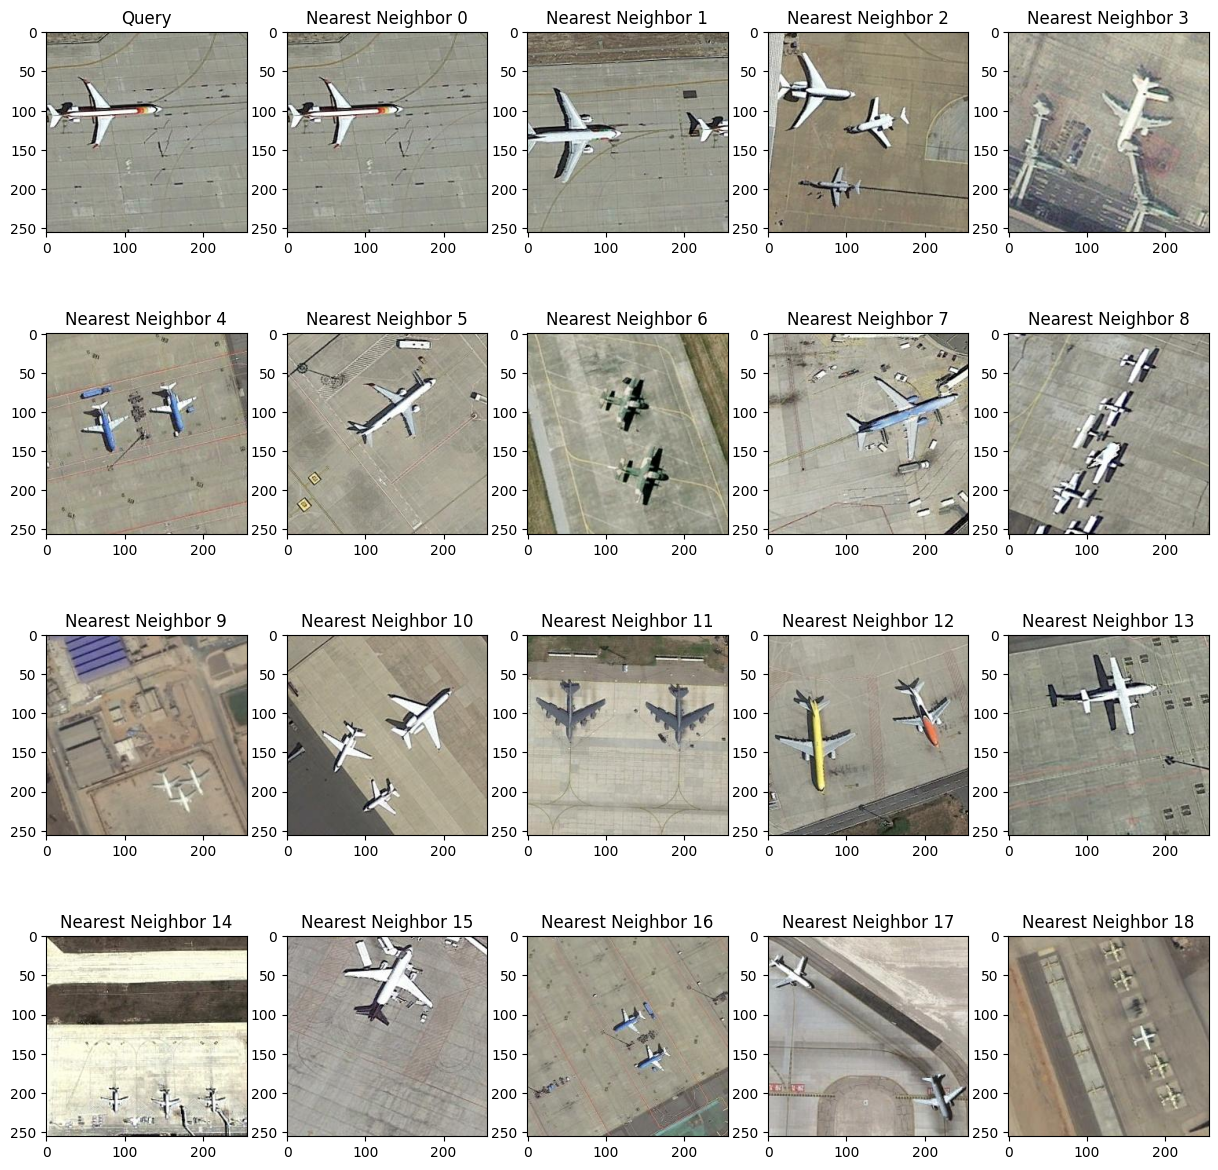

In [11]:
# Plot query image
query_image = Image.open(query_image_path)

rows, columns = 4, 5
fig, axs = plt.subplots(rows, columns, figsize=(15, 15))


n = 0
for i in range(rows):
    for j in range(columns):
        if (i == 0) and (j == 0):
            axs[0][0].imshow(query_image)
            axs[0][0].set_title(f'Query')
        else:
            axs[i][j].imshow(Image.open(image_paths[indices[0][n]]))
            axs[i][j].set_title(f'Nearest Neighbor {n}')
            n += 1
plt.show()

## Store in FAISS Index
- https://github.com/facebookresearch/faiss/wiki/Getting-started

In [11]:
d = 1000
index = faiss.IndexFlatL2(d)
print(index.is_trained)

True


In [12]:
# Walk into directoies to find images and convert them to vectors
image_paths = []
for root, dirs, files in os.walk('datasets/'):
    for file in files:
        if file.endswith((".jpg", ".tif", ".png")):
            file_path = os.path.join(root, file)
            image_paths.append(file_path)

            img = torch.tensor(np.array(Image.open(file_path)), dtype=torch.float32)[:,:,:3]
            img = img.permute(2, 0, 1).unsqueeze(0)

            with torch.no_grad():
                feature = model(img.to(device)).detach().cpu().numpy()
            index.add(feature)

print(index.ntotal, ' Images Found!')

5071  Images Found!


### Search

In [13]:
query_image_path = 'datasets/RESISC45_partial/ship/ship_608.jpg'
query = torch.tensor(np.array(Image.open(query_image_path)), dtype=torch.float32)[:,:,:3]
query = query.permute(2, 0, 1).unsqueeze(0)
with torch.no_grad():
    query_feature = model(query.to(device)).detach().cpu().numpy()

In [14]:
k = 20
D, I = index.search(query_feature, k)

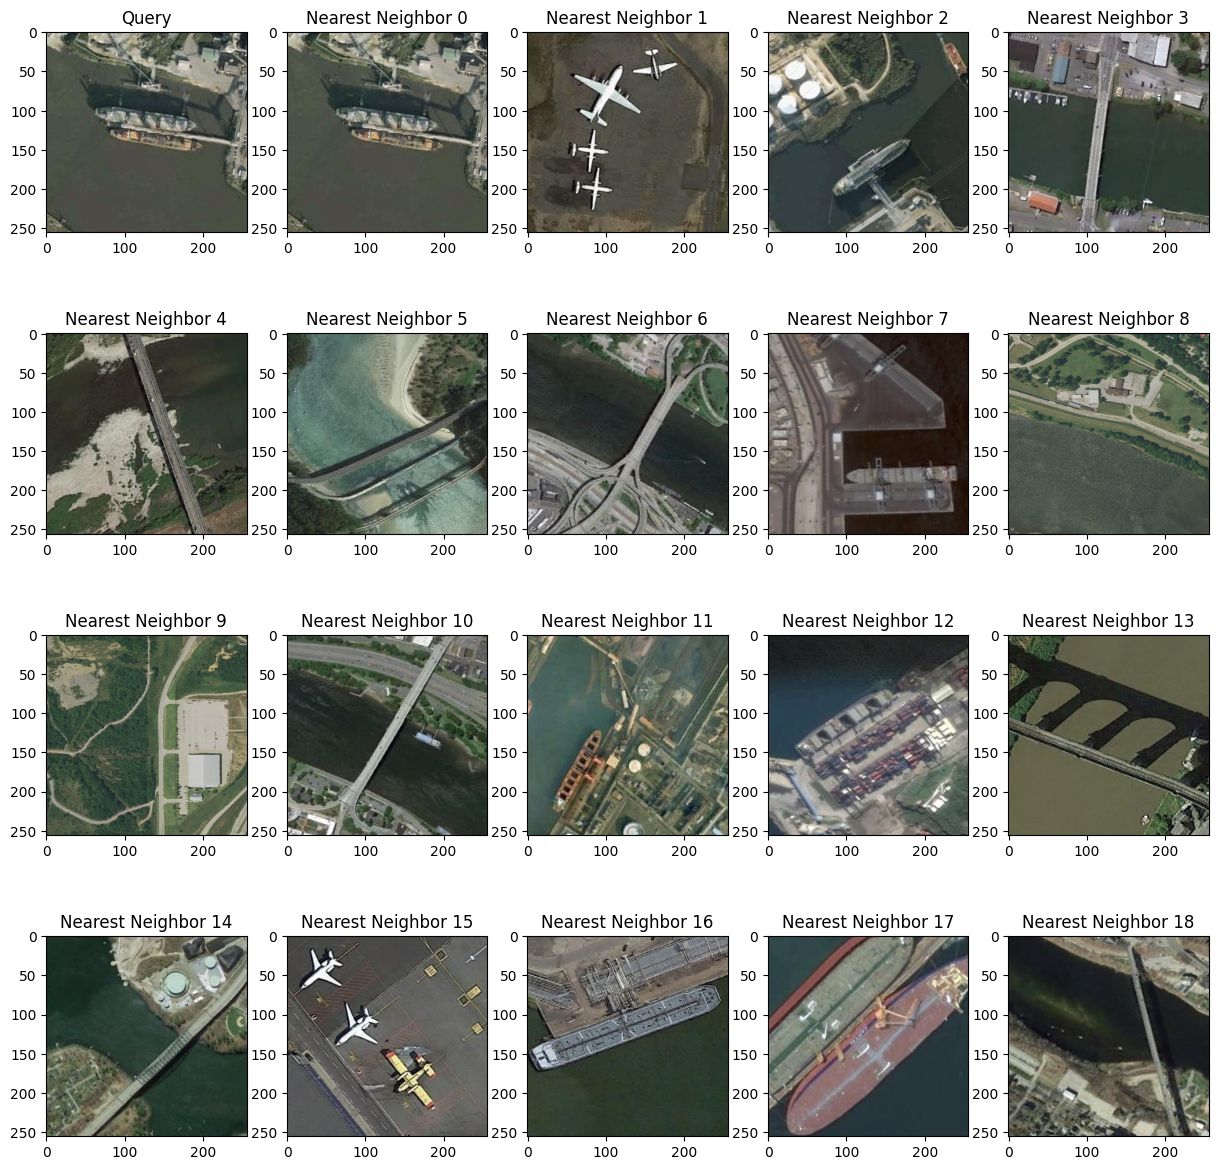

In [16]:
# Plot query image
query_image = Image.open(query_image_path)

rows, columns = 4, 5
fig, axs = plt.subplots(rows, columns, figsize=(15, 15))


n = 0
for i in range(rows):
    for j in range(columns):
        if (i == 0) and (j == 0):
            axs[0][0].imshow(query_image)
            axs[0][0].set_title(f'Query')
        else:
            axs[i][j].imshow(Image.open(image_paths[I[0][n]]))
            axs[i][j].set_title(f'Nearest Neighbor {n}')
            n += 1
plt.show()